In [1]:
import prettymaps
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, Polygon
import datetime
import itertools
import os
import glob
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint, LineString
from shapely.ops import split
from pyproj import Geod
import requests
import time

from PIL import Image

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [3]:
import rpy2
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages

rpy2.robjects.numpy2ri.activate()

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 3201, 3200
0...10...20...30...40...50...60...70...80...90...100 - done.


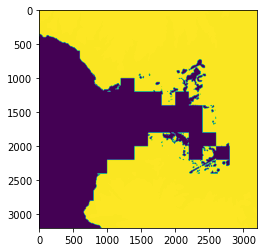

In [4]:
!gdalbuildvrt \
    -te 700997, 1604000, 717000, 1620000 \
    -overwrite -a_srs "EPSG:2154" \
    data-tmp/my777d.vrt \
    data-tmp/RGEALTI_2-0_5M_ASC_WGS84UTM20-MART87_D972_2015-10-21/RGEALTI/1_DONNEES_LIVRAISON_2020-06-00373/RGEALTI_MNT_5M_ASC_WGS84UTM20_MART87_D972/RGEALTI_MTQ_*

!gdal_translate -of GTiff -co "TILED=YES" -co COMPRESS=LZW -co BIGTIFF=YES -ot Float32 -a_srs "EPSG:2154" data-tmp/my777d.vrt data-tmp/my777d.tiff

with rio.open("data-tmp/my777d.tiff") as f:
    z = f.read(1)
    
plt.imshow(z)

In [5]:
# transform -99999 into 0
y = []
i = 0
for zz in z:
    yy = [max(0, x) for x in zz][::-1]
    y.append(yy)
yy = np.array(y, dtype=np.float32)

In [8]:
def rayshade(z, img_path=None, zscale=10, fov=0, theta=45, zoom=0.75, phi=45, windowsize=(1000, 1000)):
    
    # Output path.
    if not img_path:
        img_path = tempfile.NamedTemporaryFile(suffix='.png').name
    
    # Import needed packages.
    rayshader = rpackages.importr('rayshader')
    
    # Convert array to matrix.
    z = np.asarray(z)
    rows, cols = z.shape
    z_mat = ro.r.matrix(z, nrow=rows, ncol=cols)
    ro.globalenv['elmat'] = z_mat
    
    # Save python state to r.
    ro.globalenv['img_path'] = img_path
    ro.globalenv['zscale'] = zscale
    ro.globalenv['fov'] = fov
    ro.globalenv['theta'] = theta
    ro.globalenv['zoom'] = zoom
    ro.globalenv['phi'] = phi
    ro.globalenv['windowsize'] = ro.IntVector(windowsize)
    
    # Do the render.
    ro.r('''
        elmat %>%
          sphere_shade(texture = "desert") %>%
          add_water(detect_water(elmat), color = "desert") %>%
          add_shadow(ray_shade(elmat, zscale = 3), 0.5) %>%
          add_shadow(ambient_shade(elmat), 0) %>%
          plot_3d(elmat, zscale = zscale, fov = fov, theta = theta, zoom = zoom, phi = phi, windowsize = windowsize, baseshape = "circle")
        Sys.sleep(0.2)
        render_snapshot(img_path)
    ''')
    return img_path

In [ ]:
rayshade(yy, img_path="output/2022-11-28.png")